# Test prediction models for grating orientation 
* convolutional neural network, input features_SA and features RA of size (n_pins, n_pins) representing firing rate on an n_pins x n_pins square array                
* tested on each grating stimulus (periods 0-5mm); test data concatenated over physical grating orientation (90, 180, 270, 360)
* prediction of yaw relative to the grating orientation; range (-90,90) rescaled to (0,1)
* only two yaws are present in the test data: -45 and +45 deg (rescaled -0.5 +0.5)
* results are presented as distributions of predictions for each test yaw angle, for each grating period stimulus

To run, first edit dir_data to path where data is stored; experiment_2/process and experiment_2/train in this directory should both be run first

In [128]:
import os, pickle
import numpy as np
from sklearn.neighbors import KernelDensity
import seaborn as sn

%matplotlib inline
import matplotlib.pyplot as plt

def open_obj(name):
    with open(name + '.pkl', 'rb') as f:
        obj = pickle.load(f)
    return obj

def save_obj(obj, name):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

In [129]:
dir_data = os.environ["DATAPATH"] + r"/open/afferents-tactile-gratings-jrsi2022/experiment_2"
n_stimuli = 8
n_angles = 4
stimuli = [f'{i}' for i in range(n_stimuli)]
angles = [f'{90*a}' for a in range(n_angles)]
n_pins = 19

In [130]:
import tensorflow as tf
from keras import Model
from keras.models import load_model

model_SA = "model_47_0.18"
model_RA = "model_12_0.25"

model_SA = load_model(dir_data + rf"/models/orientation_SA/{model_SA}.hdf5")
model_RA = load_model(dir_data + rf"/models/orientation_RA/{model_RA}.hdf5")

In [131]:
X_test_SA = [[open_obj(dir_data + rf"/processed/test_data/{stimuli[i]}/{angles[j]}/X_test_sa") for j in range(n_angles)] for i in range(n_stimuli)]
y_test_SA = [[open_obj(dir_data + rf"/processed/test_data/{stimuli[i]}/{angles[j]}/y_test_sa") for j in range(n_angles)] for i in range(n_stimuli)]
X_test_RA = [[open_obj(dir_data + rf"/processed/test_data/{stimuli[i]}/{angles[j]}/X_test_ra") for j in range(n_angles)] for i in range(n_stimuli)]
y_test_RA = [[open_obj(dir_data + rf"/processed/test_data/{stimuli[i]}/{angles[j]}/y_test_ra") for j in range(n_angles)] for i in range(n_stimuli)]

X_test_SA = [np.reshape(np.stack(X_test_SA[i]), (-1,n_pins,n_pins)) for i in range(n_stimuli)]
y_test_SA = [(np.reshape(np.stack(y_test_SA[i]), (-1)) + 90)/180 for i in range(n_stimuli)] # normalise labels
X_test_RA = [np.reshape(np.stack(X_test_RA[i]), (-1,n_pins,n_pins)) for i in range(n_stimuli)]
y_test_RA = [(np.reshape(np.stack(y_test_RA[i]), (-1)) + 90)/180 for i in range(n_stimuli)] # normalise labels

result_SA = [model_SA.predict(np.expand_dims(X_test_SA[i], axis=3)) for i in range(n_stimuli)]
result_RA = [model_RA.predict(np.expand_dims(X_test_RA[i], axis=3)) for i in range(n_stimuli)]

In [132]:
A = [result_SA[i][np.argwhere(y_test_SA[i]==0.25)][:,0,0] for i in range(n_stimuli)]
B = [result_SA[i][np.argwhere(y_test_SA[i]==0.75)][:,0,0] for i in range(n_stimuli)]

save_obj(A, dir_data + r"/models/A_SA")
save_obj(B, dir_data + r"/models/B_SA")

nxs = 1000
x = np.linspace(-0.1, 1.1, nxs)[:, np.newaxis]

cross = [int(nxs/2) for i in range(n_stimuli)]
for i in range(n_stimuli):
    kde_1 = KernelDensity(kernel='gaussian', bandwidth=0.05).fit(A[i][:,np.newaxis])
    log_dens_1 = kde_1.score_samples(x)
    kde_2 = KernelDensity(kernel='gaussian', bandwidth=0.05).fit(B[i][:,np.newaxis])
    log_dens_2 = kde_2.score_samples(x)
    for cross[i] in range(int(nxs/4),int(3*nxs/4)):
        if np.exp(log_dens_2[cross[i]])>np.exp(log_dens_1[cross[i]]): break

n_samples = 1000
p_r2_s2, p_r2_s1 = [np.zeros(n_stimuli) for _ in range(2)]
for i in range(n_stimuli):
    for j in range(n_samples):
        if np.random.choice(A[i])<x[cross[i]]:
            if np.random.choice(B[i])>x[cross[i]]: p_r2_s2[i] += 1/n_samples
            if np.random.choice(A[i])>x[cross[i]]: p_r2_s1[i] += 1/n_samples
        else:
            if np.random.choice(B[i])<x[cross[i]]: p_r2_s2[i] += 1/n_samples
            if np.random.choice(A[i])<x[cross[i]]: p_r2_s1[i] += 1/n_samples         
    print(f'stimulus{stimuli[i]}: hits={p_r2_s2[i]}, false alarms={p_r2_s1[i]}')

save_obj(p_r2_s1, dir_data + r"/models/p_s1_SA")
save_obj(p_r2_s2, dir_data + r"/models/p_s2_SA")

stimulus0: hits=0.0, false alarms=0.009000000000000001
stimulus1: hits=0.005, false alarms=0.007
stimulus2: hits=0.0, false alarms=0.0
stimulus3: hits=0.0, false alarms=0.0
stimulus4: hits=0.0, false alarms=0.002
stimulus5: hits=0.0, false alarms=0.0
stimulus6: hits=0.008, false alarms=0.014000000000000005
stimulus7: hits=0.016000000000000007, false alarms=0.02000000000000001


C:\Users\nl13426\anaconda3\envs\tactip1\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\nl13426\anaconda3\envs\tactip1\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\nl13426\anaconda3\envs\tactip1\lib\site-packages\ipykernel_launcher.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  # This is added back by InteractiveShellApp.init_path()
C:\Users\nl13426\anaconda

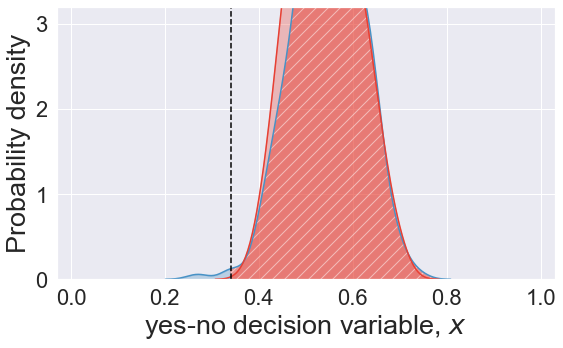

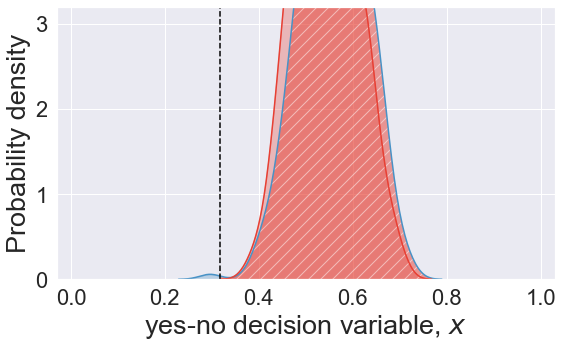

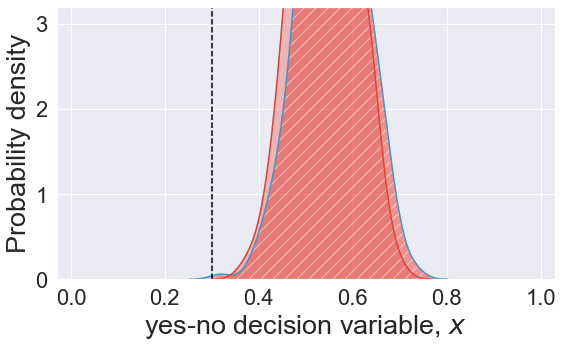

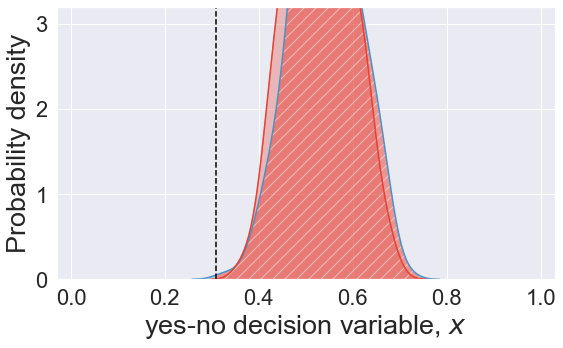

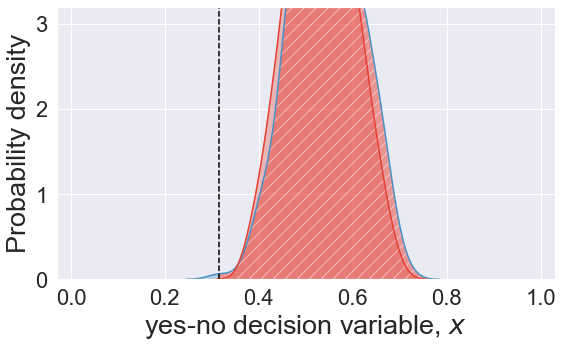

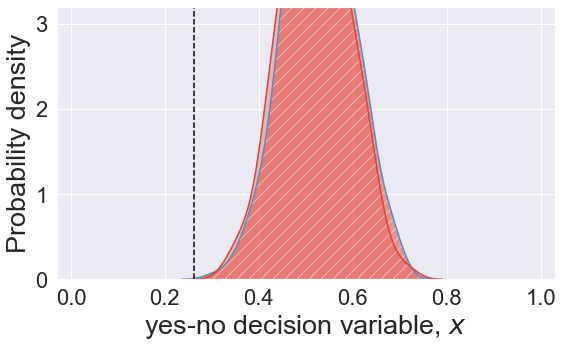

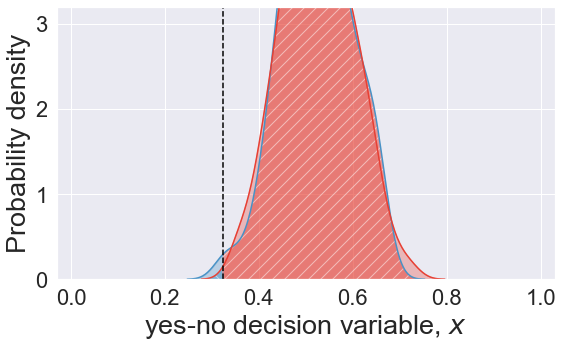

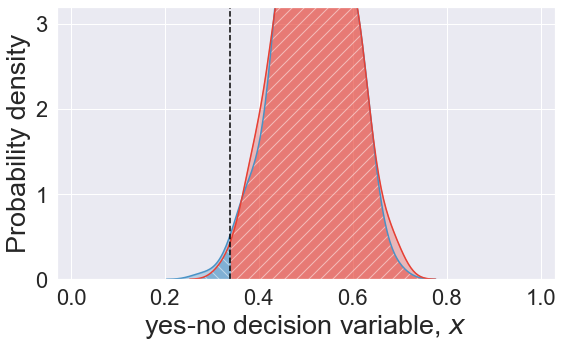

In [133]:
for i in range(n_stimuli):
    sn.set()
    fig1, axs = plt.subplots(1, figsize = (8,5))
    current_palette = sn.color_palette()
    sn.distplot(A[i], label="f(x$\mid$A)", color=sn.color_palette("Blues_d")[2], bins = 15, hist = False)
    sn.distplot(B[i], label="f(x$\mid$B)", color=sn.color_palette("Reds_d")[2], bins=15, hist = False)
    axs.set_xlabel("yes-no decision variable, $x$", size=27)
    axs.set_ylabel("Probability density", size=27)
    axs.axvline(x=x[cross[i]], color='black', linestyle='--')
    axs.set_xlim((-0.03,1.03))
    axs.set_xticklabels((-0.1,0.0,0.2,0.4,0.6,0.8,1.0), size=22)
    axs.set_yticks((0,1,2,3))
    axs.set_yticklabels((0,1,2,3), size=22)
    axs.set_ylim((0,3.2))
    plt.tight_layout()
    # axs.get_legend().remove()
    kde_x_0, kde_y_0 = axs.lines[0].get_data()
    kde_x_1, kde_y_1 = axs.lines[1].get_data()
    axs.fill_between(kde_x_0, kde_y_0, where=(kde_x_0<x[cross[i]]), interpolate=True, color=sn.color_palette("Blues_d")[2], alpha=0.3)
    axs.fill_between(kde_x_1, kde_y_1, where=(kde_x_1>x[cross[i]]), interpolate=True, color=sn.color_palette("Reds_d")[2], alpha=0.3)
    axs.fill_between(kde_x_0, kde_y_0, where=(kde_x_0>x[cross[i]]), interpolate=True, hatch='//', facecolor=sn.color_palette("Reds_d")[2], linewidth=0.0, alpha=0.5)
    axs.fill_between(kde_x_1, kde_y_1, where=(kde_x_1<x[cross[i]]), interpolate=True, hatch='\\\\', facecolor=sn.color_palette("Blues_d")[2], linewidth=0.0, alpha=0.5)

**probability of responding different given same - i.e. false alarms**

In [134]:
A = [result_RA[i][np.argwhere(y_test_SA[i]==0.25)][:,0,0] for i in range(n_stimuli)]
B = [result_RA[i][np.argwhere(y_test_SA[i]==0.75)][:,0,0] for i in range(n_stimuli)]

save_obj(A, dir_data + r"/models/A_RA")
save_obj(B, dir_data + r"/models/B_RA")

nxs = 1000
x = np.linspace(-0.1, 1.1, nxs)[:, np.newaxis]

cross = [int(nxs/2) for i in range(n_stimuli)]
# for i in range(n_stimuli):
#     kde_1 = KernelDensity(kernel='gaussian', bandwidth=0.05).fit(A[i][:,np.newaxis])
#     log_dens_1 = kde_1.score_samples(x)
#     kde_2 = KernelDensity(kernel='gaussian', bandwidth=0.05).fit(B[i][:,np.newaxis])
#     log_dens_2 = kde_2.score_samples(x)
#     for cross[i] in range(int(nxs/4),int(3*nxs/4)):
#         if np.exp(log_dens_2[cross[i]])>np.exp(log_dens_1[cross[i]]): break

n_samples = 1000
p_r2_s2, p_r2_s1 = [np.zeros(n_stimuli) for _ in range(2)]
for i in range(n_stimuli):
    for j in range(n_samples):
        if np.random.choice(A[i])<x[cross[i]]:
            if np.random.choice(B[i])>x[cross[i]]: p_r2_s2[i] += 1/n_samples
            if np.random.choice(A[i])>x[cross[i]]: p_r2_s1[i] += 1/n_samples
        else:
            if np.random.choice(B[i])<x[cross[i]]: p_r2_s2[i] += 1/n_samples
            if np.random.choice(A[i])<x[cross[i]]: p_r2_s1[i] += 1/n_samples         
    print(f'stimulus{stimuli[i]}: hits={p_r2_s2[i]}, false alarms={p_r2_s1[i]}')

save_obj(p_r2_s1, dir_data + r"/models/p_s1_RA")
save_obj(p_r2_s2, dir_data + r"/models/p_s2_RA")

stimulus0: hits=0.31900000000000023, false alarms=0.2940000000000002
stimulus1: hits=0.35100000000000026, false alarms=0.3170000000000002
stimulus2: hits=0.35400000000000026, false alarms=0.3940000000000003
stimulus3: hits=0.33300000000000024, false alarms=0.33700000000000024
stimulus4: hits=0.36000000000000026, false alarms=0.32500000000000023
stimulus5: hits=0.34200000000000025, false alarms=0.35200000000000026
stimulus6: hits=0.36000000000000026, false alarms=0.32100000000000023
stimulus7: hits=0.3820000000000003, false alarms=0.3960000000000003


C:\Users\nl13426\anaconda3\envs\tactip1\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\nl13426\anaconda3\envs\tactip1\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\nl13426\anaconda3\envs\tactip1\lib\site-packages\ipykernel_launcher.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  # This is added back by InteractiveShellApp.init_path()
C:\Users\nl13426\anaconda

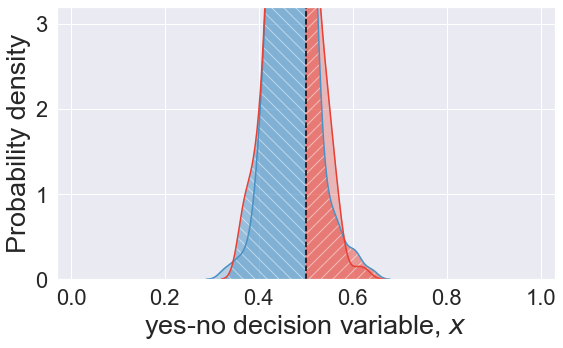

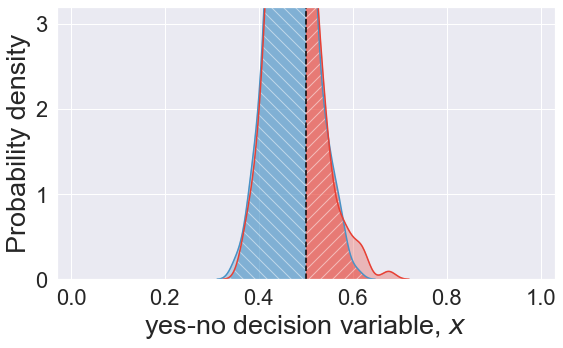

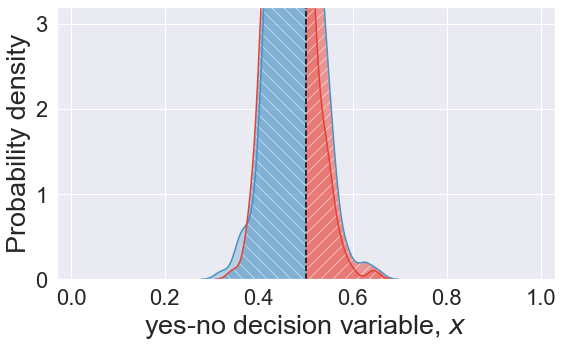

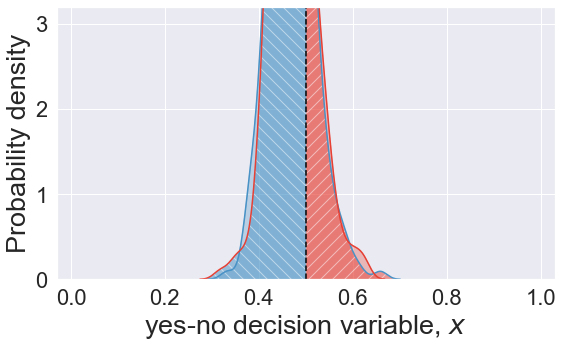

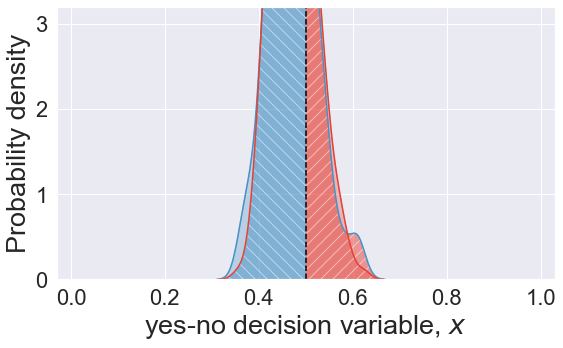

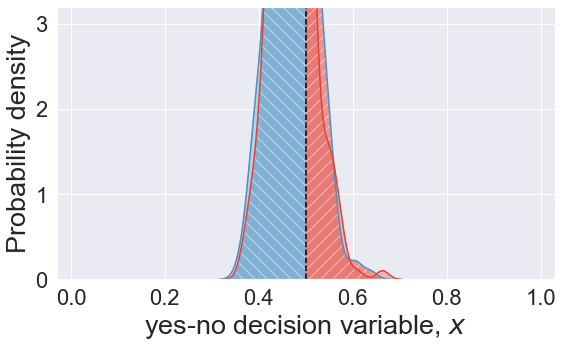

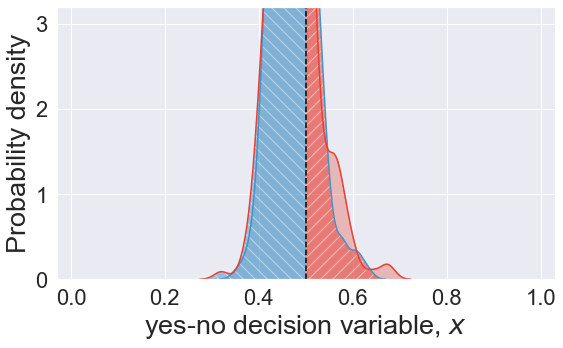

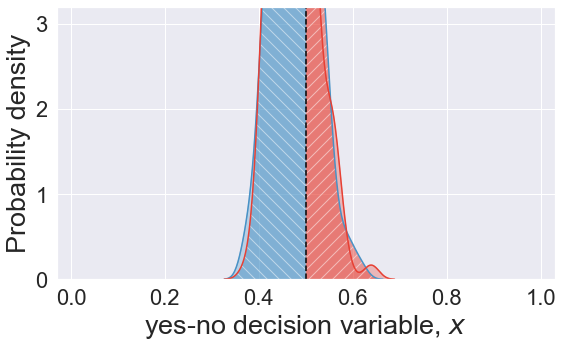

In [135]:
for i in range(n_stimuli):
    sn.set()
    fig1, axs = plt.subplots(1, figsize = (8,5))
    current_palette = sn.color_palette()
    sn.distplot(A[i], label="f(x$\mid$A)", color=sn.color_palette("Blues_d")[2], bins = 15, hist = False)
    sn.distplot(B[i], label="f(x$\mid$B)", color=sn.color_palette("Reds_d")[2], bins=15, hist = False)
    axs.set_xlabel("yes-no decision variable, $x$", size=27)
    axs.set_ylabel("Probability density", size=27)
    axs.axvline(x=x[cross[i]], color='black', linestyle='--')
    axs.set_xlim((-0.03,1.03))
    axs.set_xticklabels((-0.1,0.0,0.2,0.4,0.6,0.8,1.0), size=22)
    axs.set_yticks((0,1,2,3))
    axs.set_yticklabels((0,1,2,3), size=22)
    axs.set_ylim((0,3.2))
    plt.tight_layout()
    kde_x_0, kde_y_0 = axs.lines[0].get_data()
    kde_x_1, kde_y_1 = axs.lines[1].get_data()
    axs.fill_between(kde_x_0, kde_y_0, where=(kde_x_0<x[cross[i]]), interpolate=True, color=sn.color_palette("Blues_d")[2], alpha=0.3)
    axs.fill_between(kde_x_1, kde_y_1, where=(kde_x_1>x[cross[i]]), interpolate=True, color=sn.color_palette("Reds_d")[2], alpha=0.3)
    axs.fill_between(kde_x_0, kde_y_0, where=(kde_x_0>x[cross[i]]), interpolate=True, hatch='//', facecolor=sn.color_palette("Reds_d")[2], linewidth=0.0, alpha=0.5)
    axs.fill_between(kde_x_1, kde_y_1, where=(kde_x_1<x[cross[i]]), interpolate=True, hatch='\\\\', facecolor=sn.color_palette("Blues_d")[2], linewidth=0.0, alpha=0.5)